In [3]:
import gpxpy
import gpxpy.gpx

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate
import xarray as xr
import seaborn as sns

sns.set()
sns.set_style('darkgrid')
plt.rcParams['axes.grid'] = False

In [33]:
# import sample area border data
gpx_file = open('data/sampleborder.gpx', 'r')
gpx = gpxpy.parse(gpx_file)
gpx_file.close()

df_track = pd.DataFrame(columns=['lat', 'lon'])
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            df_track= pd.concat([df_track, pd.DataFrame({'lat': point.latitude, 'lon': point.longitude}, index=[0])], ignore_index=True)

df_track = pd.concat([df_track, pd.DataFrame({'lat': df_track.iloc[0,0], 'lon': df_track.iloc[0,1]}, index=[0])], ignore_index=True)

In [34]:
#import and create df gpx
gpx_file = open('data/221202waypoints.gpx', 'r')
gpx = gpxpy.parse(gpx_file)
gpx_file.close()

# create data frame of lat long and id
df_latlong = pd.DataFrame(columns=['id', 'lat', 'long'])
for waypoint in gpx.waypoints:
    df_latlong = pd.concat([df_latlong, pd.DataFrame({'id': [waypoint.name], 'lat': [waypoint.latitude], 'long': [waypoint.longitude]})], ignore_index=True)

In [35]:
#import and create df of measurement csv
df_measurement = pd.read_csv('data/measurement.csv', sep=',')

In [36]:
# combine lat long df with measurements
df_latlong.id = df_latlong.id.astype(int)
df = pd.merge(df_latlong, df_measurement, on='id')

# split into dataframes for before and after sample 100
df_before = df[df.id < 100]
df_after = df[df.id >= 100]

/tmp/ipykernel_12973/2952919824.py:3: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df = pd.merge(df_latlong, df_measurement, on='id')


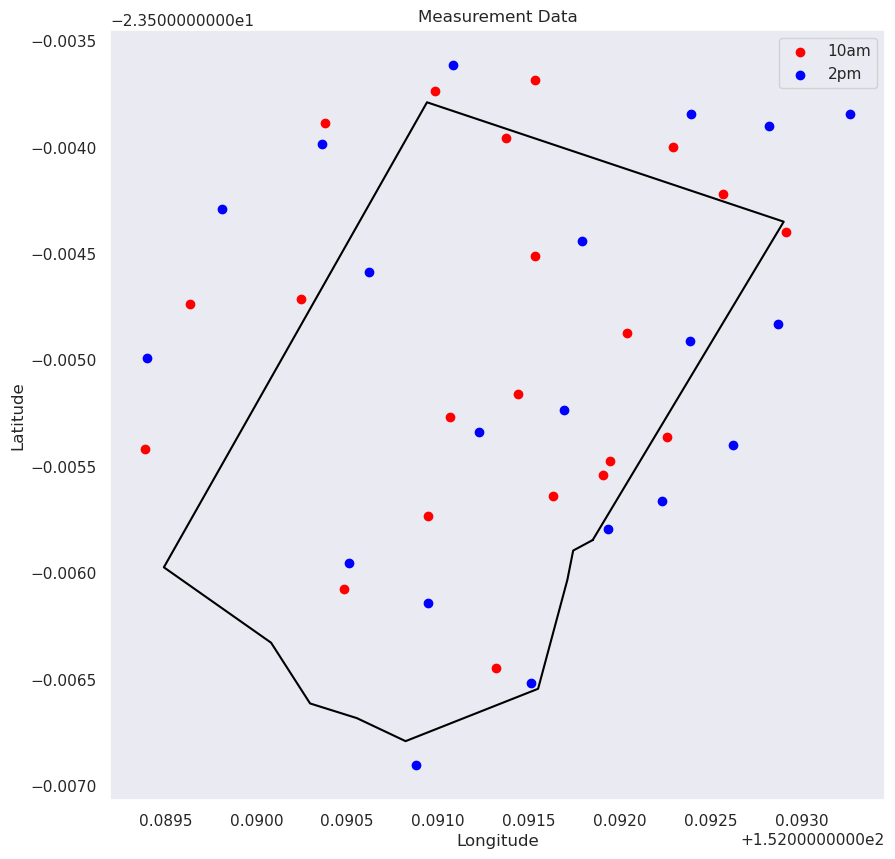

In [42]:
# plot measurements and collection border
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(df_track.lon, df_track.lat, color='black')
ax.scatter(df_before.long, df_before.lat,color='red', label='10am')
ax.scatter(df_after.long, df_after.lat, color='blue', label='2pm')
ax.legend()
ax.set_title('Measurement Data')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# save
plt.savefig('output/datapoints.png', dpi=300, bbox_inches='tight')


In [8]:
def interpolate_2D_data(df, z_type="%DO", method="linear"):
    """
    Interpolate 2D data using scipy.interpolate.griddata
    """
    # create grid
    xi = np.linspace(df.long.min(), df.long.max(), 1000)
    yi = np.linspace(df.lat.min(), df.lat.max(), 1000)
    xi, yi = np.meshgrid(xi, yi)

    # interpolate
    zi = scipy.interpolate.griddata((df.long, df.lat), df[z_type], (xi, yi), method=method)

    # return dataset
    return xr.Dataset({z_type: (["lat", "long"], zi)}, coords={"lat": yi[:, 0], "long": xi[0, :]})

In [30]:
def plot_sample_and_interpolation(df, data, interpolation_type, title, min_value, max_value):
    
    interpolated_data = interpolate_2D_data(df, data, interpolation_type)

    # create plot
    fig, ax = plt.subplots()

    # increase figure size
    fig.set_size_inches(7, 7)

    # plot interpolated data
    ax.pcolormesh(interpolated_data.long, interpolated_data.lat, interpolated_data[data], cmap='viridis', vmax=max_value, vmin=min_value)

    # plot samples
    sns.scatterplot(x=df.long, y=df.lat, hue=df[data], palette='viridis', hue_norm=(min_value, max_value), ax=ax, legend=False)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(data + ' ' + title)

    # set ticks
    ax.tick_params(axis='both', which='major', labelsize=9, labelrotation=20)
    ax.ticklabel_format(useOffset=False, style='plain')
    
    # plot colour bar
    fig.colorbar(ax.collections[0], ax=ax)

    # plot border
    ax.plot(df_track.lon, df_track.lat, color='black')
    
    # show grid
    ax.grid(True, lw=0.5)

    for i, txt in enumerate(df['id']):
        lat = df.iloc[i, 1]
        lon = df.iloc[i, 2]
        ax.annotate(txt, (lon, lat), fontsize=8)

    # save image
    file_title = title.replace(' ', '_')
    plt.savefig('output/' + data + '_' + file_title + '.png', dpi=300, bbox_inches='tight')

    

    plt.show()


    return interpolated_data


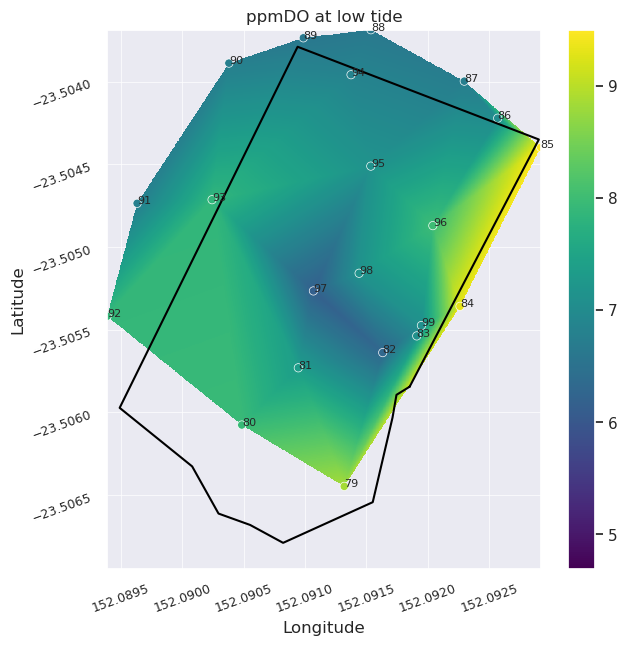

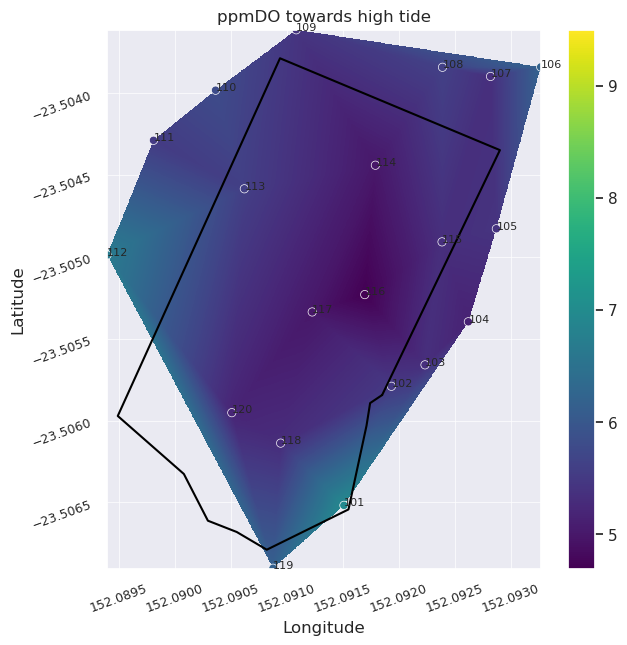

In [31]:
def compare_data(data):
    df_before_filtered = df_before[df_before[data] > 0]
    df_after_filtered = df_after[df_after[data] > 0]

    min_val = min(df_before_filtered[data].min(), df_after_filtered[data].min())
    max_val = max(df_before_filtered[data].max(), df_after_filtered[data].max())

    before_data = plot_sample_and_interpolation(df_before_filtered, data, 'linear', "at low tide", min_val, max_val)
    after_data = plot_sample_and_interpolation(df_after_filtered, data, 'linear', "towards high tide", min_val, max_val)

compare_data("ppmDO")
# compare_data("ppmDO")
# compare_data("PSU")
# compare_data("Celsius")